In [10]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np


# Load all article reviews from MediaBiasChart V5.0:
media_bias = pd.read_csv('../data/MediaBiasChart.csv')
media_bias = media_bias.groupby('Source').mean()
media_bias.reset_index(level=0, inplace=True)

MediaBiasChart_to_Tweet = {'ABC':'ABC','AP':'AP','Axios':'axios','CNN':'CNN','Wall Street Journal':'WSJ',\
    'The Atlantic':'TheAtlantic','The Hill':'thehill', 'BBC':'BBC', 'Think Progress':'thinkprogress',\
    'MSNBC':'MSNBC','The Nation':'thenation','Daily Beast':'thedailybeast','Mother Jones':'MotherJones',\
    'CNSNews':'cnsnews','Fox News':'FoxNews', 'The Federalist':'FDRLST','Breitbart':'BreitbartNews',\
    'Daily Caller':'DailyCaller','The Blaze':'theblaze','Business Insider':'businessinsider',\
    'CBS':'CBSNews','The Economist':'TheEconomist','BuzzFeed':'BuzzFeed','Daily Signal':'DailySignal',\
    'New Republic':'newrepublic','Foreign Policy':'ForeignPolicy','IJR':'TheIJR','National Review':'NRO',\
    'National Public Radio':'NPR','New York Post':'nypost','New York Times':'nytimes','The New Yorker':'NewYorker',\
    'NewsMax':'newsmax','One America News Network':'OANN','Politico':'politico','Quartz':'qz',\
    'Reason':'reason','Reuters':'Reuters','Slate':'Slate','Talking Points Memo':'TPM','Vanity Fair':'VanityFair',\
    'Vox':'voxdotcom','Washington Examiner':'dcexaminer','Washington Free Beacon':'FreeBeacon',\
    'Washington Post':'washingtonpost','Washington Times':'WashTimes','The Week':'TheWeek','Bloomberg':'Bloomberg',\
    'Christian Science Monitor':'csmonitor', 'Democracy Now':'democracynow','Financial Times':'FT',\
    'Fiscal Times':'TheFiscalTimes','Forbes':'Forbes','Fortune':'FortuneMagazine','Forward':'jdforward',\
    'FreeSpeech TV':'freespeechtv','Huffington Post':'HuffPost','LA Times':'latimes','Marketwatch':'MarketWatch',\
    'OZY':'ozy','PBS':'PBS','ProPublica':'propublica','Time':'TIME','USA Today':'USATODAY',\
    'Weather.com':'weatherchannel'}

media_bias['Source'] = media_bias.Source.map(MediaBiasChart_to_Tweet)
media_bias = media_bias.dropna()
media_bias.reset_index(drop=True)


frac = 0.2  # This frac stands for the percentage of media to be selected as left/right media
left_bound = media_bias.Bias.quantile(frac)
right_bound = media_bias.Bias.quantile(1-frac)
low_bound = media_bias.Quality.quantile(frac)
high_bound = media_bias.Quality.quantile(1-frac)
all_media = media_bias['Source'].tolist()
left_media = media_bias.loc[media_bias['Bias']<=left_bound]
left_media = left_media['Source'].tolist()
right_media = media_bias.loc[media_bias['Bias']>=right_bound]
right_media = right_media['Source'].tolist()
low_media = media_bias.loc[media_bias['Quality']<=low_bound]
low_media = low_media['Source'].tolist()
high_media = media_bias.loc[media_bias['Quality']>=high_bound]
high_media = high_media['Source'].tolist()

# Load tweets and filter out a small portion which does not have a proper 'username'
df1 = pd.read_csv('../data/filtered_part1.csv', skiprows=1)
df2 = pd.read_csv('../data/filtered_part2.csv')
df3 = pd.read_csv('../data/filtered_part3.csv')
df4 = pd.read_csv('../data/filtered_part4.csv',lineterminator='\n')
df6 = pd.read_csv('../data/filtered_part6.csv')
df7 = pd.read_csv('../data/filtered_part7.csv')
df8 = pd.read_csv('../data/filtered_part8.csv')
df = pd.concat([df1, df2, df3, df4, df6, df7, df8], sort = False)

all_media = media_bias['Source'].tolist()
df = df.loc[df['user_screen_name'].isin(all_media)]

df_2018 = df.loc[((df['created_at']) >= '2018-01-01') & ((df['created_at']) <= '2018-12-31')]
df_2018 = df_2018.reset_index(drop = True)
import preprocessor as p
df_2018['text']  = df_2018['text'].apply(p.clean)

In [3]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

2.1.0


In [4]:
vocab_size = 5000
embedding_dim = 64
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .5

In [11]:
media2bias = dict(zip(media_bias.Source, media_bias.Bias))
df_2018['bias'] = df_2018['user_screen_name'].map(media2bias)
df_2018['bias'] = df_2018['bias']/df_2018['bias'].abs().max()
media2qual = dict(zip(media_bias.Source, media_bias.Quality))
df_2018['quality'] = df_2018['user_screen_name'].map(media2qual)
df_2018['quality'] = df_2018['quality']/df_2018['quality'].abs().max()

In [12]:
articles = []
labels = []

for index, row in df_2018.iterrows():
    labels.append(row[['bias','quality']])
    article = row['text']
    for word in STOPWORDS:
        token = ' ' + word + ' '
        article = article.replace(token, ' ')
        article = article.replace(' ', ' ')
    articles.append(article)
print(len(labels))
print(len(articles))

426493
426493


In [13]:
articles[0]

'"If start separate idea movie theaters movies, fact it’s great time." Ben Fritz future streaming services movies: https://t.co/tYN2VP17we https://t.co/PFzOcMt6T4'

In [14]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

213246
213246
213246
213247
213247


In [15]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 't': 2,
 'https': 3,
 'co': 4,
 'trump': 5,
 'the': 6,
 '\r': 7,
 'rt': 8,
 'new': 9,
 'a': 10}

In [8]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[259, 269, 318, 427, 2177, 95, 1, 1, 95, 2599, 640, 693, 29, 22]


In [9]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

17
100
6
100
14
100


In [29]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

213247
(213247, 100)


In [30]:
training_label_seq = np.array(train_labels).astype('float32')
validation_label_seq = np.array(validation_labels).astype('float32')
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[-0.4980712   0.69037366]
[-0.4980712   0.69037366]
[-0.4980712   0.69037366]
(213246, 2)
[-0.0716953   0.89749014]
[-0.0716953   0.89749014]
[-0.0716953   0.89749014]
(213247, 2)


In [31]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

there free speech crisis campus it’s <OOV> <OOV> it’s liberty university schools like it ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
There free speech crisis campus, it’s Yale Middlebury. It’s Liberty University schools like it.


In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(2)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 394,434
Trainable params: 394,434
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adam', loss="mse")
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 213246 samples, validate on 213247 samples
Epoch 1/10
213246/213246 - 255s - loss: 0.0620 - val_loss: 0.0607
Epoch 2/10
213246/213246 - 245s - loss: 0.0535 - val_loss: 0.0603
Epoch 3/10
213246/213246 - 245s - loss: 0.0485 - val_loss: 0.0611
Epoch 4/10
213246/213246 - 247s - loss: 0.0439 - val_loss: 0.0617
Epoch 5/10
213246/213246 - 248s - loss: 0.0395 - val_loss: 0.0640
Epoch 6/10
213246/213246 - 250s - loss: 0.0356 - val_loss: 0.0656
Epoch 7/10
213246/213246 - 253s - loss: 0.0320 - val_loss: 0.0679
Epoch 8/10
213246/213246 - 253s - loss: 0.0290 - val_loss: 0.0703
Epoch 9/10
213246/213246 - 252s - loss: 0.0263 - val_loss: 0.0698
Epoch 10/10
213246/213246 - 260s - loss: 0.0241 - val_loss: 0.0728


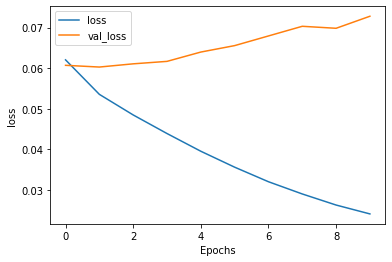

In [34]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "loss")

In [35]:
# In the future, this random sample method should be changed so that each media has exactly a half of tweets being sampled 
# into train/test...
np.random.seed(0)
sample = list(np.random.randint(2, size=len(labels)))
train_articles = [articles[i] for i in range(len(sample)) if sample[i] == 1]
train_labels = [labels[i] for i in range(len(sample)) if sample[i] == 1]
validation_articles = [articles[i] for i in range(len(sample)) if sample[i] == 0]
validation_labels = [labels[i] for i in range(len(sample)) if sample[i] == 0]

print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

213460
213460
213033
213033


In [36]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_articles)

In [37]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_label_seq = np.array(train_labels)
validation_label_seq = np.array(validation_labels)

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [38]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 394,369
Trainable params: 394,369
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(optimizer='adam', loss='mae')
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
plot_graphs(history, "loss")

In [ ]:
type(train_padded)

In [ ]:
training_label_seq[199:211,:]